In [ ]:
!pip install tensorflow==1.14.0 -q
!pip install tensorflow-gpu==1.14 -q
!pip install h5py==2.10.0 -q
!pip install scikit-learn==0.20.0 -q
!pip install anndata scanpy adjustText -q

**DON'T FORGET TO RESTART THE RUNTIME TO USE OLDER TF1, SKLEARN**







In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
!wget https://github.com/alibashir/aav/raw/main/allseqs_20191230.csv.zip --no-verbose
!unzip allseqs_20191230.csv.zip
!rm allseqs_20191230.csv.zip

2022-06-08 10:24:41 URL:https://raw.githubusercontent.com/alibashir/aav/main/allseqs_20191230.csv.zip [8437043/8437043] -> "allseqs_20191230.csv.zip" [1]
Archive:  allseqs_20191230.csv.zip
  inflating: allseqs_20191230.csv    


#preprocessing data

In [13]:
import numpy as np
import pandas as pd

In [14]:
max_length = 50

In [39]:
def encode_seq(sequence, max_length):
  alphabet = ['A', 'C', 'D', 'E', 'F', 'G','H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
  char_to_int = dict((c, i) for i, c in enumerate(alphabet))
  integer_encoded = [char_to_int[char] for char in sequence]
  onehot_encoded = list()

  for value in integer_encoded:
      letter = [0 for _ in range(len(alphabet))]
      letter[value] = 1
      onehot_encoded.append(letter)

  #pad the end of the sequence with all-0 vectors
  if len(integer_encoded) < max_length:
    for _ in range(max_length-len(integer_encoded)):
      onehot_encoded.append([0 for _ in range(len(alphabet))])

  return np.array(onehot_encoded)

In [40]:
df = pd.read_csv("./allseqs_20191230.csv")
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
df = df[['sequence', 'viral_selection']]
df = df.reset_index(drop=True)

df.shape

(296896, 2)

In [41]:
#remove sequence containing "*"
for i in range(len(df)):
  if "*" in df['sequence'][i]:
    df = df.drop(index=i)

df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.shape

(296839, 2)

In [42]:
assert df.sequence[0] == 'DCDEIRTTNPVATEQYGSVSdWVlIEtTlEtLnEs'
assert df.sequence[2] == 'NEATCsTnAtTNPVAYEQWGVVvPTdNhRdQReGdDgR'
assert df.sequence[100] == 'SLEEIRTTNPVATEQYGSVEENLQRGNR'

prepare the training data

In [19]:
aa_seq = [seq.upper() for seq in df.sequence.tolist()]
seqdata_transformed = [encode_seq(seq, max_length) for seq in aa_seq]

In [20]:
seqdata_transformed = np.asarray(seqdata_transformed)
seqdata_transformed.shape

(296839, 50, 20)

In [21]:
expressions = np.asarray(df.viral_selection).astype('float')
expressions = np.reshape(expressions , [-1,1])

train-val-test split

In [22]:
_trX = seqdata_transformed[21000:]
_trY = expressions[21000:]

_vaX = seqdata_transformed[1000:21000]
_vaY = expressions[1000:21000]

_teX = seqdata_transformed[0:1000]
_teY = expressions[0:1000]

_trX.shape , _trY.shape , _vaX.shape , _vaY.shape, _teX.shape, _teY.shape

((275839, 50, 20),
 (275839, 1),
 (20000, 50, 20),
 (20000, 1),
 (1000, 50, 20),
 (1000, 1))

In [23]:
import h5py,os
data_dir = './'

with h5py.File(os.path.join(data_dir,'_trX.h5'), 'w') as hf:
    hf.create_dataset("_trX",  data=_trX)  
    
with h5py.File(os.path.join(data_dir,'_trY.h5'), 'w') as hf:
    hf.create_dataset("_trY",  data=_trY)  

with h5py.File(os.path.join(data_dir,'_vaX.h5'), 'w') as hf:
    hf.create_dataset("_vaX",  data=_vaX)  

with h5py.File(os.path.join(data_dir,'_vaY.h5'), 'w') as hf:
    hf.create_dataset("_vaY",  data=_vaY)  

with h5py.File(os.path.join(data_dir,'_teX.h5'), 'w') as hf:
    hf.create_dataset("_teX",  data=_teX)  

with h5py.File(os.path.join(data_dir,'_teY.h5'), 'w') as hf:
    hf.create_dataset("_teY",  data=_teY)  

In [24]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
scaler.fit(np.array(_trY).reshape(-1, 1))

trX = _trX
vaX = _vaX
teX = _teX

trY = (scaler.transform(_trY)).reshape(_trY.shape)
vaY = (scaler.transform(_vaY)).reshape(_vaY.shape)
teY = (scaler.transform(_teY)).reshape(_teY.shape)

print(trX.shape , trY.shape , vaX.shape , vaY.shape  , teX.shape , teY.shape)

(275839, 50, 20) (275839, 1) (20000, 50, 20) (20000, 1) (1000, 50, 20) (1000, 1)


In [25]:
input_shape = trX.shape

#build model

In [22]:
!git clone https://github.com/1edv/evolution.git
%cd /content/evolution/

Cloning into 'evolution'...
remote: Enumerating objects: 2062, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 2062 (delta 152), reused 65 (delta 63), pack-reused 1896
Receiving objects: 100% (2062/2062), 225.29 MiB | 14.04 MiB/s, done.
Resolving deltas: 100% (1242/1242), done.
Checking out files: 100% (334/334), done.
/content/evolution


In [9]:
!cp /content/evolution/manuscript_code/aux.py .
from aux import *

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [24]:
dir_path = './'

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import gc, os
import pickle

In [4]:
##Clear Memory 
tf.reset_default_graph()
tf.keras.backend.clear_session()
gc.collect()

0

In [5]:
print(tf.__version__) #should be 1.14.0
print(keras.__version__) #should be 2.2.4-tf

1.14.0
2.2.4-tf


In [6]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.python.client import device_lib
from tensorflow.keras import Input
from tensorflow.keras.layers import  Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten , Conv1D, Concatenate , Permute
from tensorflow.keras.layers import Bidirectional,LSTM,CuDNNLSTM
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Add , LeakyReLU ,Reshape , Activation , MaxPooling1D , Lambda , Dropout
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.backend import conv1d
from tensorflow.python.keras.utils import conv_utils
from tensorflow.keras import backend as K
from tensorflow import nn

In [7]:
model_params = {
    'add_cooperativity_layer': True,
    'attention_dropout_rate': 0,
    'batch_size': 1024,
    'conv_hidden': 64,
    'conv_width_motif': 30,
    'device_type': 'gpu',
    'dropout_rate': 0.05,
    'epochs': 100,
    'input_shape': (275839, 50, 20),
    'l1_weight': 0,
    'l2_weight': 0,
    'loss': 'mean_squared_error',
    'lr': 0.001,
    'motif_conv_hidden': 256,
    'n_attention_layers': 2,
    'n_aux_layers': 1,
    'n_heads': 8,
    'n_hidden': 64,
    'n_val_epoch': 1000
}

epochs = model_params['epochs']  
batch_size =  model_params['batch_size']
n_val_epoch =  model_params['n_val_epoch']
epochs = model_params['epochs']

with open(os.path.join('/content/drive/MyDrive/AAV2_viability_DeepAttn-regression','model_params.pkl'),"wb") as f:
  pickle.dump(model_params,f)
  f.close()

In [10]:
model = fitness_function_model(model_params)
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 20)]     0                                            
__________________________________________________________________________________________________
rc__conv1d (rc_Conv1D)          [(None, 50, 256), (N 153600      input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (Non

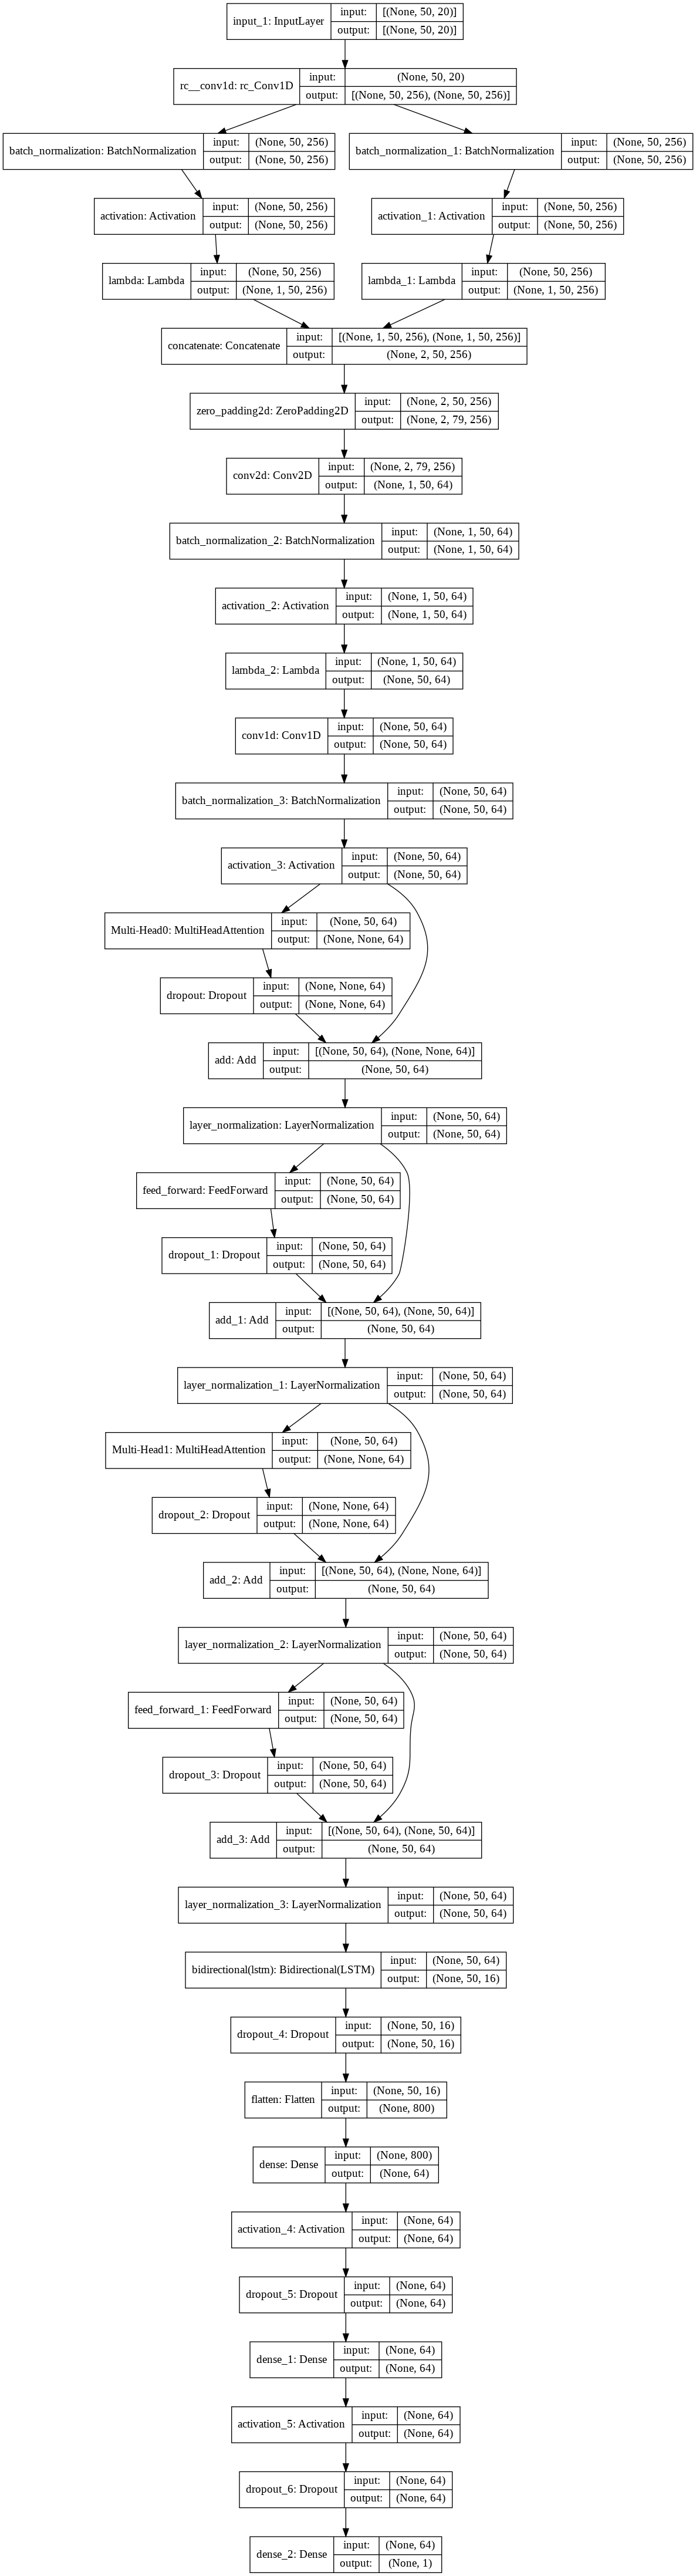

In [31]:
plot_model(model, show_shapes = 1 , show_layer_names = 1 ,to_file='model.png')

#model training

In [25]:
### Randomly select dataset for the generator for the common model
class DataGenerator(keras.utils.Sequence):
    #https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly


    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=32, shuffle=True ):
        'Initialization'
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        if self.shuffle == True:
            return int(np.floor(len(self.list_IDs) / self.batch_size))
        else:
            return int(np.ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        if self.shuffle == True:
            indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        else:
            indexes = self.indexes[index*self.batch_size:np.minimum(len(self.list_IDs),(index+1)*self.batch_size)]    

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        batch_X , batch_Y = self.__data_generation(list_IDs_temp)
        return  (batch_X , batch_Y)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp ):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        batch_X = trX[list_IDs_temp]
        batch_Y = trY[list_IDs_temp]


        return batch_X , batch_Y

In [26]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
history = LossHistory()

csvlogger = keras.callbacks.CSVLogger(os.path.join(dir_path,"loss_history.tsv"), separator='\t', append=False)
tensorboard = keras.callbacks.TensorBoard(log_dir=os.path.join(dir_path,"logs", 
                                                               datetime.datetime.now().strftime("%Y%m%d-%H%M%S")),
                                          update_freq='batch', histogram_freq=0, batch_size=batch_size, write_graph=True, 
                            write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, 
                            embeddings_metadata=None, embeddings_data=None)

checkpoint = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/AAV2_viability_DeepAttn-regression/AAV2_Protein_regressor.h5',
                                             monitor='val_r_square', 
                                             verbose=1, save_best_only=True, mode='max')

# check 5 epochs
early_stop = keras.callbacks.EarlyStopping(monitor='val_r_square', patience=10, mode='max') 

callbacks_list = [checkpoint, early_stop, history , tensorboard , csvlogger]


In [27]:
model.fit(trX, trY, validation_data = (vaX, vaY),
          batch_size=batch_size  ,
          epochs=epochs , 
          callbacks=callbacks_list 
          )

Train on 275839 samples, validate on 20000 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Epoch 1/100
275456/275839 [============================>.] - ETA: 0s - loss: 0.3830 - r_square: 0.6164
Epoch 00001: val_r_square improved from -inf to 0.67277, saving model to /content/drive/MyDrive/AAV2_viability_DeepAttn-regression/AAV2_Protein_regressor.h5
275839/275839 [==============================] - 88s 321us/sample - loss: 0.3828 - r_square: 0.6171 - val_loss: 0.3269 - val_r_square: 0.6728
Epoch 2/100
275456/275839 [============================>.] - ETA: 0s - loss: 0.1541 - r_square: 0.8457
Epoch 00002: val_r_square improved from 0.67277 to 0.78820, saving model to /content/drive/MyDrive/AAV2_viability_DeepAttn-regression/AAV2_Protein_regressor.h5
275839/275839 [==============================] - 80s 289us/sample - loss

#inference

In [ ]:
!pip install h5py==2.10.0

In [ ]:
with open('/content/drive/MyDrive/AAV2_viability_DeepAttn-regression/model_params.pkl',"rb") as f:
  model_params = pickle.load(f)

model = fitness_function_model(model_params)
model.load_weights("/content/drive/MyDrive/AAV2_viability_DeepAttn-regression/AAV2_Protein_regressor.h5" )

# Evaluate model

In [27]:
import scipy

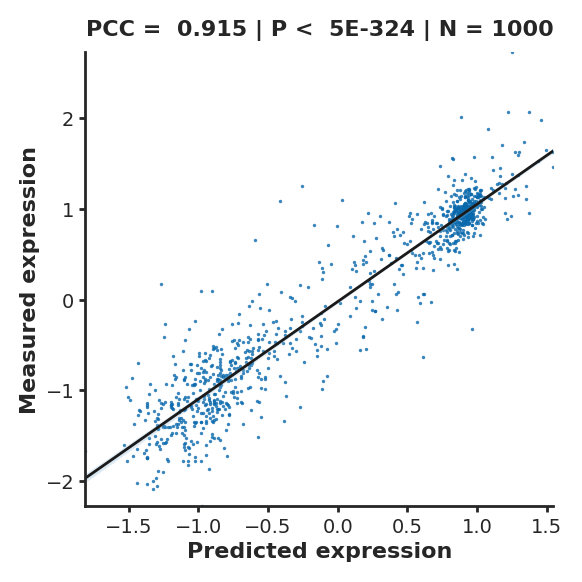

In [28]:
x=model.predict(teX)
y=teY

r = scipy.stats.spearmanr(x,y)

import seaborn as sns
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(3,3) , dpi= 200, facecolor='w', edgecolor='k')
fig.tight_layout(pad = 1)

if 1 : 
    sns.regplot(x=x ,y=y ,
                scatter_kws= {'s':1.5,'linewidth':0, 'rasterized':True} ,
                line_kws= {'linewidth':1} ,
                color= '#0868ac', robust = 1 )
else : 
    sns.scatterplot(x,y, s = 1 , linewidth = 0 , rasterized = 1,
               color= '#0868ac')


ax = plt.gca()
ax.set_xlabel("Predicted expression")
ax.set_ylabel("Measured expression")

if (r[1] ==0.0) :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P < {np.nextafter(0, 1) : 0.0E} | N = {len(x)}"  )
else :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P = {r[1] : 0.2E} | N = {len(x)}"  )

plt.setp(ax.artists, edgecolor = 'k')
plt.setp(ax.lines, color='k')
#plt.setp(ax.lines, linewidth=1.5)

ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
#ax.set_xlim(xmin=-3,xmax=3)
#ax.set_ylim(ymin=-3,ymax=3)

plt.show()

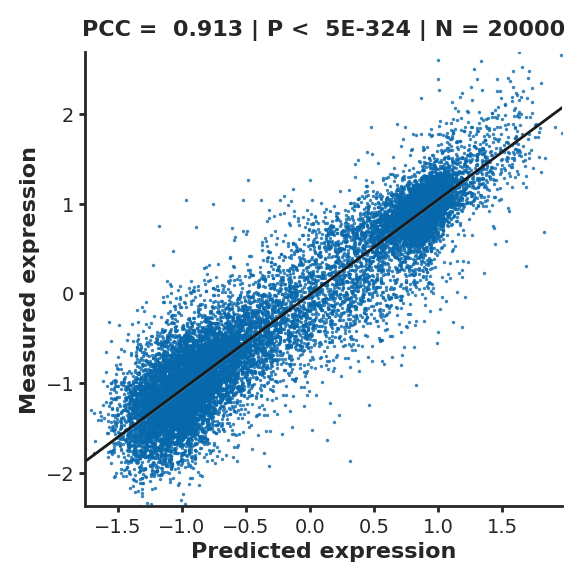

In [29]:
x=model.predict(vaX)
y=vaY

r = scipy.stats.spearmanr(x,y)

import seaborn as sns
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(3,3) , dpi= 200, facecolor='w', edgecolor='k')
fig.tight_layout(pad = 1)

if 1 : 
    sns.regplot(x=x ,y=y ,
                scatter_kws= {'s':1.5,'linewidth':0, 'rasterized':True} ,
                line_kws= {'linewidth':1} ,
                color= '#0868ac', robust = 1 )
else : 
    sns.scatterplot(x,y, s = 1 , linewidth = 0 , rasterized = 1,
               color= '#0868ac')


ax = plt.gca()
ax.set_xlabel("Predicted expression")
ax.set_ylabel("Measured expression")

if (r[1] ==0.0) :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P < {np.nextafter(0, 1) : 0.0E} | N = {len(x)}"  )
else :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P = {r[1] : 0.2E} | N = {len(x)}"  )

plt.setp(ax.artists, edgecolor = 'k')
plt.setp(ax.lines, color='k')
#plt.setp(ax.lines, linewidth=1.5)

ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
#ax.set_xlim(xmin=-3,xmax=3)
#ax.set_ylim(ymin=-3,ymax=3)

plt.show()